# Model import

In [1]:
# !pip install implicit

In [2]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
import numpy as np
import os 
import pandas as pd
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

## Data Load & 전처리

In [3]:
rating_file_path='/content/drive/MyDrive/Data/002NLP/Recommendation/movie/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [5]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [6]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'movie_id', 'counts'] # timestamp 항목 제거
ratings = ratings[using_cols]

In [7]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [8]:
ratings.head()

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [9]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path='/content/drive/MyDrive/Data/002NLP/Recommendation/movie/movies.dat'
cols = ['movie_id', 'title','genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
# 마찬가지로 사용하지 않을 genre 제거
using_cols = ['movie_id', 'title']
movies = movies[using_cols]
movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [10]:
movies['title'] = movies['title'].str.lower()

In [11]:
movies.head()

,movie_id,title
0,1,toy story (1995)
1,2,jumanji (1995)
2,3,grumpier old men (1995)
3,4,waiting to exhale (1995)
4,5,father of the bride part ii (1995)


In [12]:
movies.tail()

,movie_id,title
3878,3948,meet the parents (2000)
3879,3949,requiem for a dream (2000)
3880,3950,tigerland (2000)
3881,3951,two family house (2000)
3882,3952,"contender, the (2000)"


In [13]:
movies[1500:1510]

,movie_id,title
1500,1538,"second jungle book: mowgli & baloo, the (1997)"
1501,1539,twin town (1997)
1502,1541,addicted to love (1997)
1503,1542,brassed off (1996)
1504,1543,"designated mourner, the (1997)"
1505,1544,"lost world: jurassic park, the (1997)"
1506,1545,ponette (1996)
1507,1546,schizopolis (1996)
1508,1547,shiloh (1997)
1509,1548,"war at home, the (1996)"


1995~2000년대의 영화들이 있다.

저기에 내가 좋아 하는 영화들이 얼마나 있는진 모르겠지만 일단 ㄱㄱ

# 2) EDA

1. ratings에 있는 유니크한 영화 개수
2. ratings에 있는 유니크한 사용자 수
3. 가장 인기 있는 영화 30개(인기순)

In [14]:
#ratings에 있는 유니크한 영화 개수
num_movie = ratings['user_id'].nunique()
#ratings에 있는 유니크한 사용자 수
num_user = ratings['movie_id'].nunique()

print('number of unique movies:',num_movie)
print('number of unique users:',num_user)

number of unique movies: 6039
number of unique users: 3628


In [15]:
# 인기 많은 영화
movie_count = ratings.groupby('movie_id')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

movie_id
2858    3211
260     2910
1196    2885
1210    2716
2028    2561
589     2509
593     2498
1198    2473
1270    2460
2571    2434
480     2413
2762    2385
608     2371
110     2314
1580    2297
527     2257
1197    2252
2396    2213
1617    2210
318     2194
858     2167
1265    2121
1097    2102
2997    2066
2716    2051
296     2030
356     2022
1240    2019
1       2000
457     1941
Name: user_id, dtype: int64

### **고유한 사용자가 3628명이므로, 상위 30개의 영화는 기본적으로 53% 이상의 사람들이 본 영화이다.**

In [16]:
movie_count.describe()

count    3628.000000
mean      230.561742
std       355.596393
min         1.000000
25%        23.000000
50%        87.000000
75%       285.000000
max      3211.000000
Name: user_id, dtype: float64

최소 한 명 ~ 최대 3211명 

표준 편차 355 명

상위 50% = 87 명

영화 별 평점이 3점 이상인 인원의 편차가 크다.

# 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.

## 내가 좋아하는 영화들이 일단 인덱스에 있는지 보자.

1995~2000사이 영화 중 내가 좋아하는 영화 5개를 (굳이) 골라보면

> toy story, the matrix, man in black, the truman show, saving private ryan등이 있다. 

일단 인덱스에 있는지부터 확인해야한다.

다음 주소에서 참조했다.

https://github.com/hyyoo3526/AIFFEL_EXPLORATION/blob/main/EXPLORATION_09/EXPLORATION_IC1_09_recommendata_iu.ipynb

In [17]:
#movies data set에서 index,제목을  indexing 하는 코드
idx_to_movie = {i:v for i,v in zip(movies['movie_id'], movies['title'])}
movie_to_idx = {v:i for i,v in zip(movies['movie_id'], movies['title'])}

In [18]:
# 코드 참조 : https://github.com/hyyoo3526/AIFFEL_EXPLORATION/blob/main/EXPLORATION_09/EXPLORATION_IC1_09_recommendata_iu.ipynb
# 영화 전체 목록을 확인
for key, value in idx_to_movie.items():
    print(key, value)

1 toy story (1995)
2 jumanji (1995)
3 grumpier old men (1995)
4 waiting to exhale (1995)
5 father of the bride part ii (1995)
6 heat (1995)
7 sabrina (1995)
8 tom and huck (1995)
9 sudden death (1995)
10 goldeneye (1995)
11 american president, the (1995)
12 dracula: dead and loving it (1995)
13 balto (1995)
14 nixon (1995)
15 cutthroat island (1995)
16 casino (1995)
17 sense and sensibility (1995)
18 four rooms (1995)
19 ace ventura: when nature calls (1995)
20 money train (1995)
21 get shorty (1995)
22 copycat (1995)
23 assassins (1995)
24 powder (1995)
25 leaving las vegas (1995)
26 othello (1995)
27 now and then (1995)
28 persuasion (1995)
29 city of lost children, the (1995)
30 shanghai triad (yao a yao yao dao waipo qiao) (1995)
31 dangerous minds (1995)
32 twelve monkeys (1995)
33 wings of courage (1995)
34 babe (1995)
35 carrington (1995)
36 dead man walking (1995)
37 across the sea of time (1995)
38 it takes two (1995)
39 clueless (1995)
40 cry, the beloved country (1995)
41 ri

영화 제목들에서 'the'가 붙은 영화들은 명사뒤 ,(쉼표)를 붙이고 뒤에 'the'를 붙인다.

이를 바탕으로 내가 좋아하는 영화 제목들 과 상영 연도를 검색해 리스트를 작성하였다.

In [19]:
my_favorite_movie = ['toy story (1995)','matrix, the (1999)','men in black (1997)', 'truman show, the (1998)','saving private ryan (1998)']
# 코드 참조 :https://github.com/hyyoo3526/AIFFEL_EXPLORATION/blob/main/EXPLORATION_09/EXPLORATION_IC1_09_recommendata_iu.ipynb
#내가 좋아하는 영화들이 데이터셋안에 있는지 확인하는 코드.
for i in my_favorite_movie:
    print(movies.isin({'title':[i]})['title'].any())

True
True
True
True
True


다행히 좋아하는 영화들이 모두 데이터 안에 있었다.

In [20]:
# 코드 참조 :https://github.com/hyyoo3526/AIFFEL_EXPLORATION/blob/main/EXPLORATION_09/EXPLORATION_IC1_09_recommendata_iu.ipynb
# 좋아하는 영화의 인덱스번호를  별도의 리스트에 넣어줍니다.
my_idx = []
for i in my_favorite_movie:
    my_idx.append(movie_to_idx[i])
my_idx

[1, 2571, 1580, 1682, 2028]

In [21]:
# 내가 좋아하는 영화를 점수와 함께 삽입한다.
my_favorite= pd.DataFrame({'user_id': ['4242']*5,'movie_id':my_idx, 'counts':[5]*5})
# 나와 같은 user id가 없을 때 ratings에 추가
if not ratings.isin({'user_id':['4242']})['user_id'].any():
    ratings = ratings.append(my_favorite)
ratings.tail(10)

,user_id,movie_id,counts
1000203,6040,1090,3
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4
1000208,6040,1097,4
0,4242,1,5
1,4242,2571,5
2,4242,1580,5
3,4242,1682,5
4,4242,2028,5


In [22]:
num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()
print('user_id:', num_user)
print('movie_id:', num_movie)

user_id: 6040
movie_id: 3628


# 4) CSR matrix를 직접 만들어 봅시다.

In [23]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = ratings['user_id'].unique()
movie_unique = ratings['movie_id'].unique()

# 유저, 영화 id를 indexing 하는 코드
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [24]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['4242'])    # 6039 나와야 함
print(movie_to_idx[1580])     # men in black 의 movie_id

6039
175


In [25]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_ratings = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_ratings) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_ratings   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# movie_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_ratings = ratings['movie_id'].map(movie_to_idx.get).dropna()
if len(temp_movie_ratings) == len(ratings):
    print('movie column indexing OK!!')
    ratings['movie_id'] = temp_movie_ratings
else:
    print('movie column indexing Fail!!')

ratings

user_id column indexing OK!!
movie column indexing OK!!


,user_id,movie_id,counts
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5
...,...,...,...
0,6039,40,5
1,6039,124,5
2,6039,175,5
3,6039,385,5


In [26]:
# csr_data = csr_matrix((ratings['counts'], (ratings.user_id, ratings.movie_id)))
csr_data = csr_matrix((ratings['counts'], (ratings.user_id, ratings.movie_id)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

# 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.

## 모델 훈련

In [27]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=20, dtype=np.float32)

In [28]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
# csr_data_transpose = csr_data.T
# csr_data_transpose

In [29]:
# 모델 훈련
als_model.fit(csr_data)

  0%|          | 0/20 [00:00<?, ?it/s]

# 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

image.png

## Movie_id

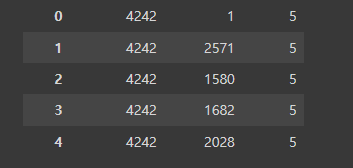

## Movie_id_to_idx

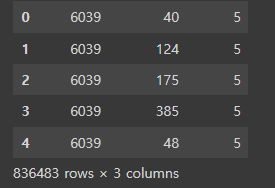

In [45]:
movie_to_idx[1580] # 맨인블랙

175

In [47]:
my, black  = user_to_idx['4242'], movie_to_idx[1580] # 맨 인블랙 (1997) 의 movie_id
my_vector, black_vector = als_model.user_factors[my], als_model.item_factors[black]

In [41]:
np.dot(my_vector, black_vector)

0.5199802

# 다른 유사한 영화들을 추천

In [42]:
similar_movie = als_model.similar_items(2571) # matrix 의 movie id
similar_movie   # (movie idx, 유사도) Tuple

(array([2571,  823,  275, 2582, 2444, 2566, 2576, 1154, 2584, 2590],
       dtype=int32),
 array([1.0000001, 0.7261084, 0.7127536, 0.7103442, 0.7047471, 0.7044546,
        0.701297 , 0.6936964, 0.6679138, 0.6639276], dtype=float32))

In [34]:
def print_sim(movie_id):
    sim_movies = []
    similar_movie = als_model.similar_items(movie_id)
    for i in similar_movie[0]:
        a=idx_to_movie[i]
        sim_movies.append(a)
    return sim_movies

In [35]:
my_idx

[1, 2571, 1580, 1682, 2028]

In [36]:
for i in my_idx:
    print('My favorite movie :',idx_to_movie[i])
    print(print_sim(i))

My favorite movie : toy story (1995)
['toy story (1995)', 'carrington (1995)', 'new york cop (1996)', 'his girl friday (1940)', 'star trek: generations (1994)', 'cosi (1996)', 'babe (1995)', 'leaving las vegas (1995)', 'twelve monkeys (1995)', 'shanghai triad (yao a yao yao dao waipo qiao) (1995)']
My favorite movie : matrix, the (1999)
['matrix, the (1999)', 'collectionneuse, la (1967)', 'mixed nuts (1994)', 'twin dragons (shuang long hui) (1992)', '24 7: twenty four seven (1997)', "doug's 1st movie (1999)", 'love, etc. (1996)', 't-men (1947)', 'foolish (1999)', 'hideous kinky (1998)']
My favorite movie : men in black (1997)
['men in black (1997)', 'wild bunch, the (1969)', 'misérables, les (1998)', 'untouchables, the (1987)', 'grandfather, the (el abuelo) (1998)', 'hard 8 (a.k.a. sydney, a.k.a. hard eight) (1996)', 'super mario bros. (1993)', 'go (1999)', 'dick (1999)', 'liar liar (1997)']
My favorite movie : truman show, the (1998)
['truman show, the (1998)', 'horse whisperer, the (

# 내가 좋아할 만한 영화 추천

In [55]:
user_to_idx['4242']

6039

recommend 메서드에서

```filter_already_liked_items=False``` 옵션으로 바꾸니 에러 없이 잘 실행된다. 왜 인지는 잘 모르겠다.

In [74]:
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=False)
movie_recommended

(array([ 48, 124, 107,  87,  92, 175,  40,  50, 141,  62, 385, 160,   4,
        248,  23, 110, 150, 145, 372,  39], dtype=int32),
 array([0.639786  , 0.58071816, 0.5318808 , 0.5267422 , 0.5263543 ,
        0.5199802 , 0.48444438, 0.40401036, 0.3522441 , 0.32812852,
        0.31779563, 0.29646906, 0.28098077, 0.27762878, 0.26840007,
        0.26838258, 0.26784652, 0.2549031 , 0.2513088 , 0.24194437],
       dtype=float32))

In [71]:
[idx_to_movie[i] for i in movie_recommended[0]]

['pocahontas (1995)',
 "star maker, the (uomo delle stelle, l') (1995)",
 'muppet treasure island (1996)',
 'dunston checks in (1996)',
 'mary reilly (1996)',
 'kids (1995)',
 'cry, the beloved country (1995)',
 'usual suspects, the (1995)',
 'birdcage, the (1996)',
 "mr. holland's opus (1995)",
 'man of no importance, a (1994)',
 'congo (1995)',
 'waiting to exhale (1995)',
 'houseguest (1994)',
 'assassins (1995)',
 'braveheart (1995)',
 'apollo 13 (1995)',
 'bad boys (1995)',
 'reality bites (1994)',
 'clueless (1995)']

추천받은 20개 영화들 중 포카혼타스가 가장 관련성이 높은 영화로 나오는데 나름 관심이 있었던 영화 중 하나였다. 나머지는 잘 모르는 영화라 추천 받은 영화들이 내 취향에 맞는지는 잘 모르겠다.

# 회고

crs_data 를 만들 때, num_user과 num_data 를 넣지 않고 만들었을 때 오류가 발생 하지 않았다. 

비슷한 영화 끼리 추천 했을 땐 에러 없이 잘 추천했지만, 정작 사용자 id로 검색 했을 땐 에러때문에 결과를 볼 수 없었다.

이번 노드에서 제목을 인덱스로, 인덱스를 제목으로 정보를 저장하는 등의 딕셔너리를 만드는 테크닉을 사용하여 정보를 정리하는 방식은 배울 점이 있었다.

그러나 이상한 곳에서 에러가 발생해 시간을 많이 잡아먹어 짜증이 많이 나는 노드였다.